# Digital Skills: Automated Image and Video Data Analysis with Python
## _University of Lucerne (Jan. 25, 2024)_
### Instructor:
### Dr. Natalia Umansky (University of Zurich)


___
___

# Session 2: Supervised Classification

<ins>**Objectives:**</ins>

  - **load and implement pre-trained CNN**: you'll learn how to load and use a pre-trained CNN to generate class/image predictions on your images.


  - **fine-tune a pre-trained CNN**: you'll learn how to fine-tune a pre-trained CNN to perform a new task of interest to you.

<ins>**Datasets:**</ins>

  - **world leaders dataset**: a dataset with sample open source images for 5 world leaders that we (Nora Webb Williams and I) put together a while back.

  - **protest dataset**: a dataset with sample images of street protests, related to BLM protests (and images that are not of protests), that also Nora and I put together.

<ins>**Key module/s:**</ins>

  - **PyTorch**: there are many deep learning library/modules for python (e.g. keras, pytorch, tensorflow). I started using PyTorch a while back. Back then they made it very easy to e.g. use open-source pre-trained models and modify the architecture of those models. These days all these libraries have really good and similar functionalities. I'll stick to pytorch in these tutorials, but any of these libraries would do the trick.

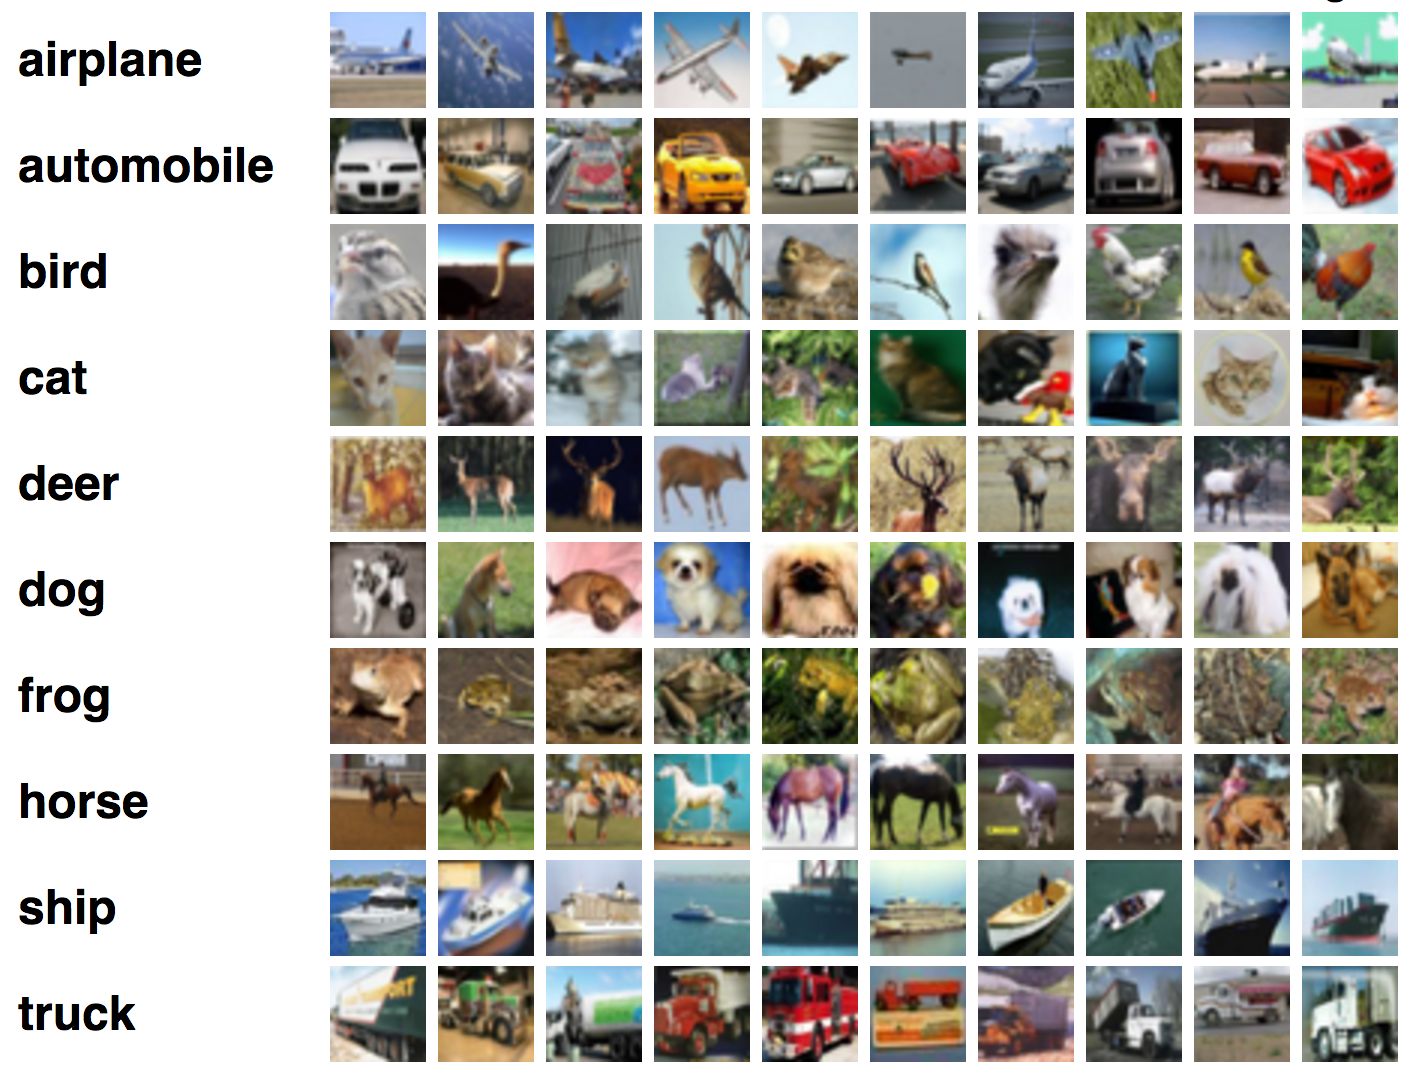

___
___

## 0. Install the packages/modules that we'll be using. Set up GPU.

These google-colab notebooks allow us to run code in virtual machines located elsewhere. Every time we start a session, the virtual machine is "empty", so non-native python modules need to be installed. Let's install the ones we'll need in this particular notebook. We'll do so using `pip` and the `!` marker that allows us to run `bash` code in the same notebook.

In [1]:
# - before getting started, set up GPU.
import torch

# - get the GPU device name.
device_name = torch.cuda.get_device_name(0)

# - the device name should look like the following:
if torch.cuda.device_count() >= 1:
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: Tesla T4


## 1. Load the modules that we'll be using

In [2]:
from google.colab import drive # module to mount the google drive
import os
from PIL import Image
import json
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# - pytorch for deep learning modeling
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

## 2. Mount the Google Drive for the workshop to this virtual machine

In [4]:
# - it will generate a url. Click on it, specify the google account you want to
#   use, and give access to it
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## 3. Declare the data path

In [5]:
data_path = '/content/gdrive/MyDrive/lucerne-digital-skills/data/'

## 4. Load a pre-trained model and perform zero-shot classfication

`PyTorch` make it very easy to load and use CNN models that have been trained on huge datasets and perform very very well at predicting a specific set of image-classes/objects (e.g. car, truck, chair, horse, person, etc.). Let's first learn how to load these pre-trained models using pytorch, and then use the model to classify some sample images (what's commonly known as zero-shot classification).

In [6]:
# - load pre-trained image model: Resnet50.
model = models.resnet50(pretrained=True)

# - set up the model to "evaluation" mode: so to avoid the model for training
#   further and the weights to be updated. We only want to generate predictions.
model.eval()

# - activate the GPU option, to make sure we're using it
model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# - load an image to use for testing
img_path = '{}dog.jpeg'.format(data_path)
img = Image.open(img_path).convert('RGB')

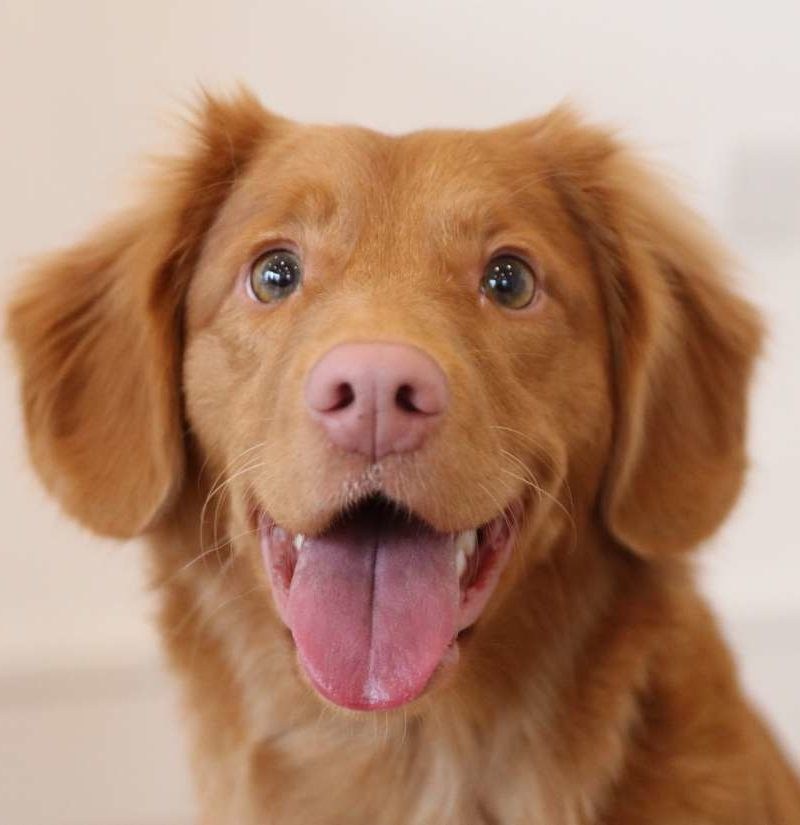

In [13]:
img

In [14]:
# - a function to preprocess an image file so it fits the Resnet input requirements.
#   This function already does the cropping and resizing for you. It also makes
#   sure that the color distribution follows that of the data used for training
#   the original model
def data_tranform(train = True, mean = [0.485, 0.456, 0.406],
                  sd = [0.229, 0.224, 0.225],
                  scale = 256, random_crop = 224):
    """
    Description: This function creates an object to transform train and
        test (or only testing) images.
    Parameters:
        `train`: type <bool> indicating if the object will need to be used
                    to transform training and testing images (=True) or
                    only testing.
        `mean`: type <list> of 3 floats indicating the mean value of the 3 RGB
                    image inputs.
        `sd`: type <list> of 3 floats indicating the standard deviation of
                    the 3 RGB mean inputs.
        `scale`: type <int> indicating the new size to give to the train and
                    test data (e.g. 256x256 pixel images).
        `random_crop`: type <int> indicating the size of the part of the image
                    really used for training-testing (e.g. 224x224)
    Output:
        An object to be used for preprocessing the train and test images
    Example:
        preprocess = data_transform()
    """
    if train:
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(scale),
                transforms.RandomResizedCrop(random_crop),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, sd)
            ]),
            'test': transforms.Compose([
                transforms.Resize(scale),
                transforms.CenterCrop(random_crop),
                transforms.ToTensor(),
                transforms.Normalize(mean, sd)
            ]),
        }
    else:
        data_transforms = transforms.Compose([
            transforms.Resize(scale),
            transforms.CenterCrop(random_crop),
            transforms.ToTensor(),
            transforms.Normalize(mean, sd)
        ])
    return(data_transforms)

In [15]:
# - initialize the data_transform object that we'll use to pre-process the image
pre_processor = data_tranform(train = False)

# - initialize a softmax function that we'll use for generating Prob. predictions
softmax = torch.nn.Softmax(dim = 0)

In [16]:
# ... preprocess/normalize the image
img_transformed = Variable(pre_processor(img).unsqueeze(0))
# ... model predictions
model_out = model(img_transformed.cuda()).cpu()

In [17]:
# ... from logits to predicted Pr.
pred_probs = softmax(model_out[0])

In [18]:
# ... pull the maximum predicted pr and class
max_pr, max_class = torch.max(pred_probs, dim = 0)
print('Max Class: {} | Max Pr: {}'.format(max_class, max_pr))

Max Class: 215 | Max Pr: 0.4031156897544861


In [20]:
# - what is the class #215? How can we find out? A list of the 1,000 ImageNet
#   class number and label can be found e.g. here:
#   https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

# - I already saved a copy of this file in our data directory. Let's load it
#   and look up the class label for 215
labels = json.load(open('{}imagenet_class_index.json'.format(data_path, 'rb')))

In [21]:
labels['215']

['n02101388', 'Brittany_spaniel']

In [22]:
# - feel free to take a look at the 1,000 classes of the ImageNet dataset. Most
#   of these pre-trained models are trained on this data -- and so predict the
#   same 1,000 classes
labels

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

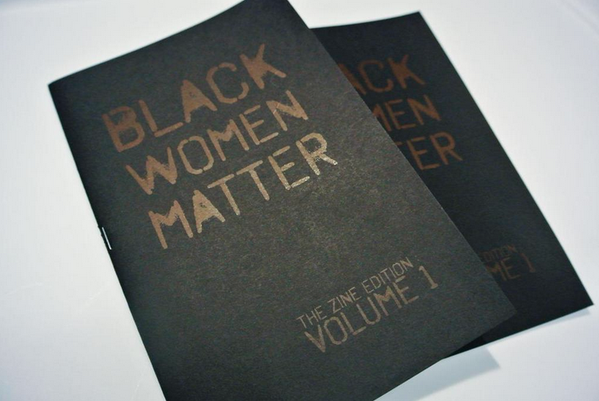

In [23]:
# - let's try the same thing with this other image
img_path = '{}protest/train/negative/55572.jpg'.format(data_path)
img = Image.open(img_path).convert('RGB')
img

In [24]:
# ... preprocess/normalize the image
img_transformed = Variable(pre_processor(img).unsqueeze(0))
# ... model predictions
model_out = model(img_transformed.cuda()).cpu()
# ... from logits to predicted Pr.
pred_probs = softmax(model_out[0])
# ... pull the maximum predicted pr and class
max_pr, max_class = torch.max(pred_probs, dim = 0)
print('Max Class: {} | Max Pr: {} | Label: {}'.format(
    max_class, max_pr,
    labels[str(max_class.numpy())][1]))

Max Class: 539 | Max Pr: 0.3284355103969574 | Label: doormat


## 5. Fine-tuning a pre-trained model

A pre-trained model may do poorly in classifying images into some classes of interest to us. If that's the case, we can try to leverage the many things the model has already learned by being trained on millions on images, but then adapt it to our particular classification task. To do so, we'll need to:
- (a) adapt the model architecture, by replacing the final fully connected layer for a layer that fits our classification task (so predicting e.g. 2 rather 1,000 classes)
- (b) train the pre-trained model for a few more iterations

We'll now practice how to do this by fine-tuning a pre-trained model to predict a binary outcome: whether an image is of a street **protest**. In order to do so, we have already **collected** and **annotated** some data for our quantity of interest (so we have some images we know are of street protests and some images we know are not).

### Data structure

Here a look at how your data needs to be set up to fit the requirements of the `ImageFolder` and `DataLoader` utilities in pytorch.

* `root-data-folder`
  - `train`
    - `class-label`
      - `img`
      - `img`
      - ...
    - `class-label`
      - `img`
      - `img`
      - ...
    - ...
  - `test`
    - ...
      - ...
  - `val`
    - ...
      - ...


Here for example how it's set up for the data we'll now use to fine-tune the model to predict images of street protests.

* `protest`
  - `train`
    - `negative`
      - `img`
      - `img`
      - ...
    - `positive`
      - `img`
      - `img`
      - ...
  - `test`
    - `negative`
      - `img`
      - `img`
      - ...
    - `positive`
      - `img`
      - `img`
      - ...

In [25]:
# - load a pre-trained model: e.g. Resnet50
model = models.resnet50(pretrained=True)

In [26]:
# - specifying HYPERPARAMETERS (researcher's choice! Some rules of thumb, but
#   usually you should perform a grid search --try many setups-- to see which
#   particular hyperparameter configuration works best)

# - specify the new number of outcome classes: 2 (binary: protest | not-protest)
num_classes = 2

# - how often do you want the loop to print information about model performance
report_num = 1 # ... every iteration

# - hyperparameters
set_learn_rate = 0.0001 # Enter the desired learning rate
set_momentum = .9 # Enter the desired momentum
set_step_size = 7 # Enter the desired step size
set_gamma = 0.1 # Enter the desired gamma
iter_num = 10 # Enter the desired number of iterations
set_batch_size = 4 # Enter the desired batch size

In [27]:
# - check number of features in last fully connected layer
num_ftrs = model.fc.in_features

# - change the output layer from 1,000 classes to a binary outcome
model.fc = nn.Linear(num_ftrs, num_classes) # For ResNet50, last step is 2048 -> 2

In [28]:
# - specify some additional hyperparameters
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(model.parameters(),
                         lr=set_learn_rate,
                         momentum=set_momentum) # how to perform optimization
scheduler = lr_scheduler.StepLR(optimizer,
                                       step_size=set_step_size,
                                       gamma=set_gamma) # how to update learning rate

In [29]:
# - initialize preprocessing object
preprocess = data_tranform()

In [30]:
# - specify the path to data for this particular classifier
model_path = '{}protest/'.format(data_path)

# - specifying where the train and test images are
image_datasets = {x: datasets.ImageFolder(os.path.join(model_path, x),
                                          preprocess[x]) for x in ['train', 'test']}

# - creating an object to easily load the train and test images
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=set_batch_size,
                                             shuffle=True)
              for x in ['train', 'test']}

# - getting some extra information such as the size of the dataset and the
#       class number
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# - making sure again that we're using GPU. Also, taking the opportunity to check
#   the model architecture and making sure that the "prediction head" has been
#   replaced and is now set up to predict a binary outcome.
use_gpu = True # /!\ Set to False if you run it in a machine with no GPUs
if use_gpu:
  model.cuda()

#### Model Training/Fine-tuning

In [31]:
# - check the size of the train and test sets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

# - initialize a time object so we can check how long the training
#   takes
since = time.time()

# - initialize a matrix of weights (model parameters) and accuracy
#   object where we'll save the weights and accuracy info for the
#   most accurate weights-configuration
best_model_wts = model.state_dict() # /!\ This may lead to overfitting.
best_acc = 0.0
best_precision = 0.0
best_recall = 0.0
loss_progress = []
acc_progress = []


for iteration in range(iter_num):
    if iteration % report_num == 0:
        print('Iteration {}/{}'.format(iteration + 1, iter_num))
        print('-' * 10)

    # - each iteration has a training and testing phase
    for phase in ['train', 'test']:
        if phase == 'train':
            scheduler.step() # update model weights
            model.train(True)  # set model to training mode
        else:
            model.train(False)  # set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        running_preds = []
        running_labels = []

        # - iterate over data: in training iteration we
        #   iterate through groups of 4 train and 4 test
        #   images.
        for data in dataloaders[phase]:
            # - get the inputs
            inputs, labels = data

            # - transform data and labels into PyTorch variables
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            # - gradients back to 0 (re-calculated in each iteration)
            optimizer.zero_grad()

            # - forward propagation: applying dot products
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            preds_int_list = list(preds)
            labels_int_list = list(labels.data)
            loss = criterion(outputs, labels)

            # (only in training phase)
            # - backward propagation: calculate loss and gradients
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # - calculate accuracy statistics
            running_loss += loss.data
            running_corrects += torch.sum(preds == labels.data)
            running_preds = running_preds + preds_int_list
            running_labels = running_labels + labels_int_list

        iter_loss = running_loss / dataset_sizes[phase]
        iter_acc = running_corrects / dataset_sizes[phase]
        if sum(running_preds) > 0:
            iter_recall = sum([1 for i in range(0, len(running_preds)) if
                                  running_preds[i] == 1 and
                                  running_labels[i] == 1]) / float(sum(running_labels))
            iter_precision = sum([1 for i in range(0, len(running_preds)) if
                                     running_preds[i] == 1 and
                                     running_labels[i] == 1]) / float(sum(running_preds))
        else:
            iter_recall = 0
            iter_precision = 0

        # - report training progress once every N (e.g. 10) iterations
        if iteration % report_num == 0:
            print('{} Loss:{:.4f} Acc:{:.4f} Precision:{:.4f} Recall:{:.4f}\n'.format(
                phase, iter_loss, iter_acc, iter_precision, iter_recall))

        # - if this iteration's results are the best so far,
        #   saving a copy of this best model
        if phase == 'test' and iter_acc > best_acc:
            best_acc = iter_acc
            best_precision = iter_precision
            best_recall = iter_recall
            best_model_wts = model.state_dict()
        if phase == 'test':
            # - keep track of the evolution of the loss and accuracy
            loss_progress.append(iter_loss.cpu())
            acc_progress.append(iter_acc.cpu())

    # - if the accuracy is already pretty high, move to next
    #   classifier
    if best_acc > 0.95 and best_precision > 0.95 and best_recall > 0.95:
        print('... reached good model accuracy, moving to next model.')
        break

# - check how long it took to estimate the model and report
#   time and results for the most accurate model weights
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}\n\n'.format(best_acc))

Iteration 1/10
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss:0.1686 Acc:0.6059 Precision:0.5882 Recall:0.7059

test Loss:0.1352 Acc:0.6667 Precision:0.6000 Recall:1.0000

Iteration 2/10
----------
train Loss:0.1275 Acc:0.7647 Precision:0.7320 Recall:0.8353

test Loss:0.0956 Acc:0.8667 Precision:0.8235 Recall:0.9333

Iteration 3/10
----------
train Loss:0.1109 Acc:0.8882 Precision:0.8667 Recall:0.9176

test Loss:0.0728 Acc:0.9000 Precision:0.8750 Recall:0.9333

Iteration 4/10
----------
train Loss:0.0937 Acc:0.8941 Precision:0.9036 Recall:0.8824

test Loss:0.0585 Acc:0.9333 Precision:0.9333 Recall:0.9333

Iteration 5/10
----------
train Loss:0.0785 Acc:0.9059 Precision:0.8791 Recall:0.9412

test Loss:0.0488 Acc:0.9000 Precision:0.8750 Recall:0.9333

Iteration 6/10
----------
train Loss:0.0754 Acc:0.8882 Precision:0.9024 Recall:0.8706

test Loss:0.0410 Acc:0.9667 Precision:1.0000 Recall:0.9333

Iteration 7/10
----------
train Loss:0.0725 Acc:0.9000 Precision:0.9146 Recall:0.8824

test Loss:0.0470 Acc:0.9667 Precision:1.0000 Recall:0.933

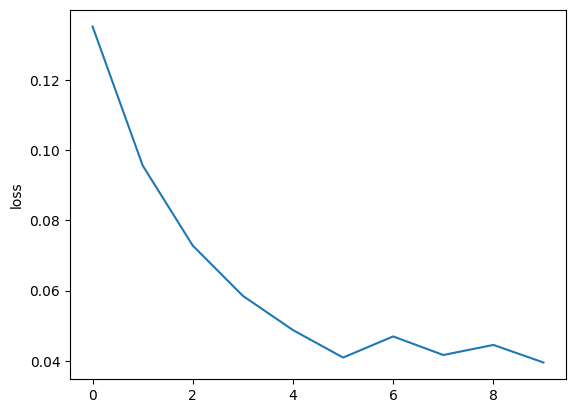

In [32]:
# - take a look at the evolution of the model loss
plt.plot(loss_progress)
plt.ylabel('loss')
plt.show()
plt.show()

In [33]:
# - save the best model weights and accuracy.
#   # /!\ This may lead to overfitting: not always the best practice. You can
#   also skip this next line and later save the model weights as they stand after
#   the last iteration.
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [34]:
# - here a function we created to more easily visualize the predictions this
#   fine-tuned model can make
def imshow(inp, title=None):
    """
    Description: This function takes a grid of images and shows them, making
        image visualization easy.
    Parameters:
        `inp`:      type <torch.FloatTensor> object.
        `title`:    type <list> of strings indicating the labels of the `inp`
                        images.
    Output:
        shows the images and their labels (if provided)
    """
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_model(model, class_names, num_images, dataloaders, use_gpu):
    """
    Description: This function shows N (<num_images>) model predictions (top
        label + top probability).

    Parameters:
        `model`: type <torchvision.models.-modeltype->, the trained model.
        `num_images`: type <int> indicating the number of random images to show.
        `dataloaders`: type <dict> of a 'train' and a 'test
            torch.utils.data.dataloader.DataLoader.
        `use_gpu`: type <bol> indicating whether CUDA is available.

    Output:
        Prints out N predictions
    """
    images_so_far = 0

    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

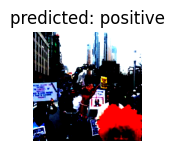

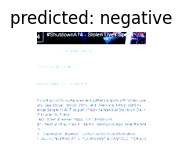

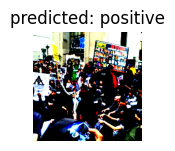

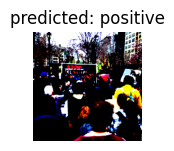

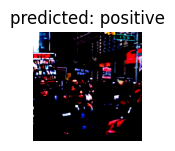

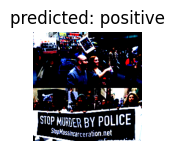

In [35]:
# - let's use it to check how the model classify some of the images in the test
#   set.
visualize_model(model = model,
                class_names = class_names,
                num_images = 6,
                dataloaders = dataloaders,
                use_gpu = use_gpu)

#### Saving, loading, and using the fine-tuned model

In [36]:
# - first create an new 'models' subdirectory in your output directory, where
#   we'll save the fine-tuned model

output_path = '/content/gdrive/MyDrive/lucerne-digital-skills/output/'
output_path02 = '{}/models/'.format(output_path)
if not os.path.isdir(output_path02):
  os.mkdir(output_path02)

In [37]:
# - PyTorch comes with a function to easily save models
model_filepath = '{}protest-model.pth'.format(output_path02)
torch.save(model, model_filepath)

In [38]:
# - here is how you can reload the model again
model_new = torch.load(model_filepath)

In [39]:
# - using the model for generating predictions

# - load some example images to test how to use, on a "new" set of images, a model
#   you previously trained
pos_path = '{}protest/test/positive/'.format(data_path)
neg_path = '{}protest/test/negative/'.format(data_path)
pos_list = ['{}{}'.format(pos_path, x) for x in os.listdir(pos_path)[:5]]
neg_list = ['{}{}'.format(neg_path, x) for x in os.listdir(neg_path)[:5]]
test_img_path_list = pos_list + neg_list
new_dataset = []
for img_file in test_img_path_list:
    img = Image.open(img_file).convert('RGB')
    new_dataset.append(img)

In [40]:
len(new_dataset)

10

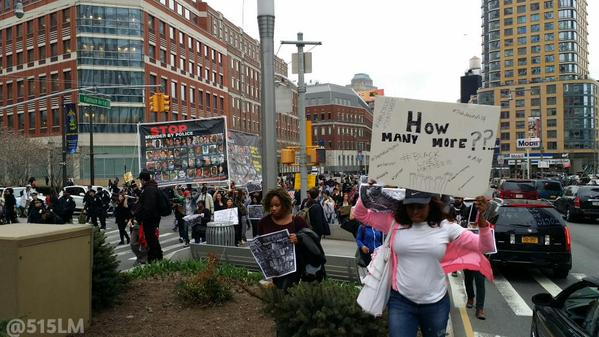

In [41]:
new_dataset[0]

In [42]:
# - specifying the transformation-preprocessing to apply to the images
preprocess = data_tranform(train = False)

# - checking if the machine has GPUs and enabling GPU computing if so
use_gpu = torch.cuda.is_available()

In [43]:
# - use the model to perform predictions on this "new" set of images
# ... initialize output dataset and a counter
sigmoid = nn.Sigmoid() # Sigmoid rather than Softmax activation: binary outcome
output_data = pd.DataFrame()
counter = 0
total = len(new_dataset)
# ... iterate through the new images to predict
for z in range(0, len(new_dataset)):
    counter += 1
    print('image: {}/{}'.format(counter, total))
    img_filename = test_img_path_list[z]
    img = new_dataset[z]
    # ... initialize output dict object for this iteration/img
    new_entry = {}
    # ... transform-preprocess this imags
    var = Variable(preprocess(img).unsqueeze(0))
    # ... make the model prediction
    pred = model_new(var.cuda())
    # ... pull the predicted class probabilities and create a dataframe with them
    probs, indeces = sigmoid(pred).cpu().data.sort()
    probs = [round(x, 3) for x in list(probs.numpy()[0])]
    indeces = list(indeces[0][:2])
    labels = [['negative', 'positive'][i] for i in indeces]
    pred_df = pd.DataFrame({'label':labels,
                            'probs':probs})
    pred_df_t = pred_df.transpose()
    final_pred_df = pd.DataFrame(pred_df_t.iloc[1]).transpose()
    final_pred_df.columns = labels
    # ... adding some extra information about the image and prediction
    final_pred_df['img'] = '/'.join(img_filename.split('/')[-2:])
    final_pred_df['max_class'] = ['negative', 'positive'][indeces[1]]
    final_pred_df['max_pr'] = max(probs)
    output_data = pd.concat([output_data, final_pred_df])
output_data = output_data.reset_index(drop=True)

image: 1/10
image: 2/10
image: 3/10
image: 4/10
image: 5/10
image: 6/10
image: 7/10
image: 8/10
image: 9/10
image: 10/10


In [44]:
output_data

,negative,positive,img,max_class,max_pr
0,0.197,0.83,positive/52723.jpg,positive,0.830
1,0.131,0.942,positive/52870.jpg,positive,0.942
2,0.453,0.645,positive/9920.jpg,positive,0.645
3,0.234,0.837,positive/53260.jpg,positive,0.837
4,0.103,0.931,positive/37456.jpg,positive,0.931
5,0.789,0.361,negative/954.jpg,negative,0.789
6,0.717,0.434,negative/335.jpg,negative,0.717
7,0.9,0.198,negative/7896.jpg,negative,0.900
8,0.527,0.516,negative/8590.jpg,negative,0.527
9,0.832,0.288,negative/45130.jpg,negative,0.832


## 6. Fine-tuning multiclass classifier

Use the `world_leaders` dataset we put together to practice fine-tuning for a multiclass classifier. In this case we have sample face images for 6 world leaders, most of them not in power anymore, this is from a while back... :)

In [47]:
# - load a pre-trained model: e.g. Resnet50
model = models.resnet50(pretrained=True)

# - specifying HYPERPARAMETERS (researcher's choice! Some rules of thumb, but
#   usually you should perform a grid search --try many setups-- to see which
#   particular hyperparameter configuration works best)

# - specify the new number of outcome classes: /!\ 6 THIS TIME
num_classes = 6

# - how often do you want the loop to print information about model performance
report_num = 1 # ... every iteration

# - hyperparameters
set_learn_rate = 0.0001 # Enter the desired learning rate
set_momentum = .9 # Enter the desired momentum
set_step_size = 7 # Enter the desired step size
set_gamma = 0.1 # Enter the desired gamma
iter_num = 10 # Enter the desired number of iterations
set_batch_size = 4 # Enter the desired batch size

# - check number of features in last fully connected layer
num_ftrs = model.fc.in_features

# - change the output layer from 1,000 classes to a binary outcome
model.fc = nn.Linear(num_ftrs, num_classes) # For ResNet50, last step is 2048 -> 6

# - specify some additional hyperparameters
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(model.parameters(),
                         lr=set_learn_rate,
                         momentum=set_momentum) # how to perform optimization
scheduler = lr_scheduler.StepLR(optimizer,
                                       step_size=set_step_size,
                                       gamma=set_gamma) # how to update learning rate

# - initialize preprocessing object
preprocess = data_tranform()

# - specify the path to data for this particular classifier
model_path = '{}world_leaders/'.format(data_path)

# - specifying where the train and test images are
image_datasets = {x: datasets.ImageFolder(os.path.join(model_path, x),
                                          preprocess[x]) for x in ['train', 'test']}

# - creating an object to easily load the train and test images
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=set_batch_size,
                                             shuffle=True)
              for x in ['train', 'test']}

# - getting some extra information such as the size of the dataset and the
#       class number
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# - making sure again that we're using GPU. Also, taking the opportunity to check
#   the model architecture and making sure that the "prediction head" has been
#   replaced and is now set up to predict a binary outcome.
use_gpu = True # /!\ Set to False if you run it in a machine with no GPUs
if use_gpu:
  model.cuda()

In [48]:
# - check the size of the train and test sets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

# - initialize a time object so we can check how long the training
#   takes
since = time.time()

# - initialize a matrix of weights (model parameters) and accuracy
#   object where we'll save the weights and accuracy info for the
#   most accurate weights-configuration
best_model_wts = model.state_dict()
best_acc = 0.0
best_precision = 0.0
best_recall = 0.0
loss_progress = []
acc_progress = []

# -
for iteration in range(iter_num):
    if iteration % report_num == 0:
        print('Iteration {}/{}'.format(iteration + 1, iter_num))
        print('-' * 10)

    # - each iteration has a training and testing phase
    for phase in ['train', 'test']:
        if phase == 'train':
            scheduler.step() # update model weights
            model.train(True)  # set model to training mode
        else:
            model.train(False)  # set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        running_preds = []
        running_labels = []

        # - iterate over data: in training iteration we
        #   iterate through groups of 4 train and 4 test
        #   images.
        for data in dataloaders[phase]:
            # - get the inputs
            inputs, labels = data

            # - transform data and labels into PyTorch variables
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            # - gradients back to 0 (re-calculated in each iteration)
            optimizer.zero_grad()

            # - forward propagation: applying dot products
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            preds_int_list = list(preds)
            labels_int_list = list(labels.data)
            loss = criterion(outputs, labels)

            # (only in training phase)
            # - backward propagation: calculate loss and gradients
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # - calculate accuracy statistics
            running_loss += loss.data #.item()
            running_corrects += torch.sum(preds == labels.data) #.item()
            running_preds = running_preds + preds_int_list
            running_labels = running_labels + labels_int_list

        iter_loss = running_loss / dataset_sizes[phase]
        iter_acc = running_corrects / dataset_sizes[phase]
        # - report training progress once every N (e.g. 10) iterations
        if iteration % report_num == 0:
            print('{} Loss:{:.4f} Acc:{:.4f}\n'.format(
                phase, iter_loss, iter_acc))

        # /!\ I CALCULATE ACCURACY DIFFERENTLY FOR MULTICLASS (v. BINARY)
        # ... (calculating precision and recall by class)
        if phase == 'test':
            for class_i in range(0, len(class_names)):
                labels_class_i_indices = [i for i in range(0, len(running_labels)) if running_labels[i] == class_i]
                preds_class_i_indices = [i for i in range(0, len(running_preds)) if running_preds[i] == class_i]
                correctly_recalled = [x for x in labels_class_i_indices if x in preds_class_i_indices]
                correctly_predicted = [x for x in preds_class_i_indices if x in labels_class_i_indices]
                if len(correctly_recalled) > 0:
                    class_recall = round(len(correctly_recalled) / round(len(labels_class_i_indices)), 2)
                else:
                    class_recall = 0
                if len(correctly_predicted) > 0:
                    class_precision = round(len(correctly_predicted) / round(len(preds_class_i_indices)), 2)
                else:
                    class_precision = 0
                print('... %s precision: %s | recall: %s'%(class_names[class_i], class_precision, class_recall))
            print('\n\n')

        # - if this iteration's results are the best so far,
        #   saving a copy of this best model
        if phase == 'test' and iter_acc > best_acc:
            best_acc = iter_acc
            best_model_wts = model.state_dict()
        if phase == 'test':
            # - keep track of the evolution of the loss and accuracy
            loss_progress.append(iter_loss)
            acc_progress.append(iter_acc)

    # - if the accuracy is already pretty high, move to next
    #   classifier
    if best_acc > 0.95 and best_precision > 0.95 and best_recall > 0.95:
        print('... reached good model accuracy, moving to next model.')
        break

# - check how long it took to estimate the model and report
#   time and results for the most accurate model weights
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}\n\n'.format(best_acc))

Iteration 1/10
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss:0.4464 Acc:0.1875

test Loss:0.4353 Acc:0.4340

... ESP precision: 0.27 | recall: 0.4
... JPN precision: 0.8 | recall: 0.8
... KAZ precision: 0.38 | recall: 0.6
... USA precision: 0.22 | recall: 0.67
... VEN precision: 1.0 | recall: 0.1
... ZAF precision: 1.0 | recall: 0.2



Iteration 2/10
----------
train Loss:0.4205 Acc:0.3667

test Loss:0.3916 Acc:0.5283

... ESP precision: 0.39 | recall: 0.7
... JPN precision: 0.86 | recall: 0.6
... KAZ precision: 1.0 | recall: 0.1
... USA precision: 0.22 | recall: 0.67
... VEN precision: 1.0 | recall: 0.2
... ZAF precision: 0.62 | recall: 1.0



Iteration 3/10
----------
train Loss:0.3905 Acc:0.4417

test Loss:0.3276 Acc:0.8113

... ESP precision: 0.69 | recall: 0.9
... JPN precision: 0.83 | recall: 1.0
... KAZ precision: 0.91 | recall: 1.0
... USA precision: 0.4 | recall: 0.67
... VEN precision: 1.0 | recall: 0.4
... ZAF precision: 1.0 | recall: 0.8



Iteration 4/10
----------
train Loss:0.3613 Acc:0.5458

test Loss:0.2833 Acc:0.9434

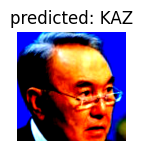

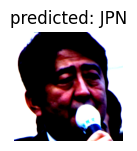

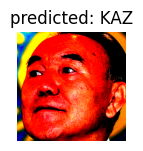

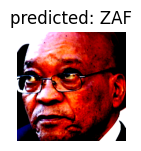

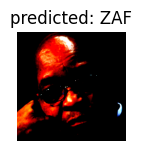

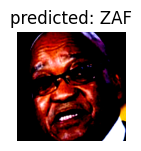

In [49]:
# - let's also take a look at some of the predictions of this fine-tuned model
visualize_model(model = model,
                class_names = class_names,
                num_images = 6,
                dataloaders = dataloaders,
                use_gpu = use_gpu)